In [80]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import gensim

from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0).reset_index(drop=True)
data.head(5)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East


In [22]:
# concatenate all the reviews for each restaurant
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(5)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,matcha soft serve parfait deluxe s850 strong m...
1,https://www.burpple.com/136-hong-kong-street-f...,favourite tze char place zhi char feast family...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,amaze four hand dinner chef alvin chef jay fou...
3,https://www.burpple.com/25-degrees-singapore?b...,burger oh yesh loveeeee burger goooooood locat...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,firebird 15 signature firebird koreaninspired ...


## Doc2Vec Modelling

In [16]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        dlist = list(set(dlist).difference(stopword_set))
        new_data.append(dlist)
    return new_data

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc, [self.labels_list[idx]])

In [17]:
# tokenize reviews
tokenized_reviews = nlp_clean(restaurant_review_df['cleaned_text'])

In [28]:
# label reviews with the restaurant url
it = LabeledLineSentence(tokenized_reviews, restaurant_review_df['url'])
# it.labels_list[0], it.doc_list[0])

In [39]:
# doc2vec
model = gensim.models.Doc2Vec(vector_size=1000, min_count=5, alpha=0.025, min_alpha=0.025) #### TO TUNE
model.build_vocab(it)
model.train(it, total_examples= model.corpus_count, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

print(model.corpus_count) ## check the corpus
print(model.docvecs.count) # check doc2vec

845
845


## Similarity

In [42]:
# get most similar restaurant to the first restaurant
# 'https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes'
model.docvecs.most_similar(0)

[('https://www.burpple.com/two-men-bagel-house-3?bp_ref=%2Ff%2FOl34wo0t',
  0.9999991655349731),
 ('https://www.burpple.com/woodlands-sourdough?bp_ref=%2F%40jmissingq%2Ftimeline',
  0.9999991655349731),
 ('https://www.burpple.com/whelers-yard?bp_ref=%2Ff%2F-F3FmrYV',
  0.9999991655349731),
 ('https://www.burpple.com/bread-yard-1?bp_ref=%2Ff%2FOkK_Y1Ce',
  0.9999991059303284),
 ('https://www.burpple.com/bakerybrera?bp_ref=%2F%40timtam_tum%2Ftimeline',
  0.9999991059303284),
 ('https://www.burpple.com/bread-yard?bp_ref=%2Ff%2FTq1oMXxT',
  0.9999990463256836),
 ('https://www.burpple.com/uminamisg?bp_ref=%2Ff%2FQk7vUeQl',
  0.9999990463256836),
 ('https://www.burpple.com/two-men-bagel-house?bp_ref=%2Ff%2FwMzOHDqo',
  0.9999990463256836),
 ('https://www.burpple.com/thespotsg?bp_ref=%2Ff%2FMIs7i9Cn',
  0.9999990463256836),
 ('https://www.burpple.com/two-men-bagel-house-novena?bp_ref=%2F%40benjaminho833%2Ftimeline',
  0.9999990463256836)]

In [41]:
# similarity between 2 documents
model.docvecs.similarity(it.labels_list[0], it.labels_list[1])

0.9999968

In [69]:
similarity_df = pd.DataFrame()

for restaurant in it.labels_list:
    similarity_list = []
    for restaurant2 in it.labels_list:
        similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
    
    similarity_df[restaurant] = similarity_list

In [75]:
similarity_df.index = list(it.labels_list)

In [83]:
similarity_df

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999997,0.999997,0.999998,...,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999998
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999997,1.000000,0.999997,0.999997,0.999997,0.999996,0.999995,0.999996,0.999996,0.999996,...,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997,0.999997
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999999,0.999997,1.000000,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999999,0.999999
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999999,0.999997,0.999999,1.000000,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999999,0.999997,0.999999,0.999999,1.000000,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999999,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,0.999999,0.999999,0.999999
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999999,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999998,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,0.999999,0.999999
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999998,0.999997,0.999998,0.999999,0.999999,0.999998,0.999997,0.999997,0.999997,0.999997,...,0.999999,0.999999,0.999998,0.999998,0.999999,0.999999,0.999999,1.000000,0.999998,0.999998
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999998,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999997,...,0.999999,0.999999,0.999998,0.999998,0.999999,0.999999,0.999999,0.999998,1.000000,0.999999


## Text Clustering using K-Means

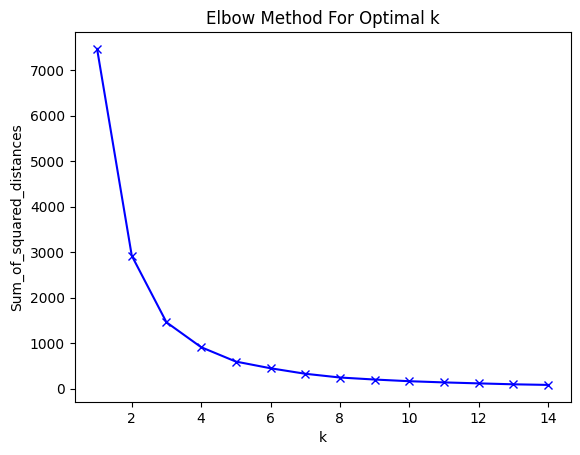

In [48]:
# get optimal number of topics
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    X = kmeans.fit(model.docvecs.doctag_syn0) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
# elbow result shows 8 is the best
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=100)
X = kmeans.fit(model.docvecs.doctag_syn0)
labels = kmeans.labels_.tolist()

In [116]:
l = kmeans.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

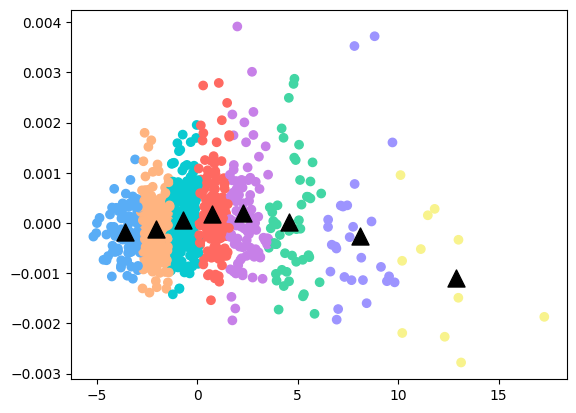

In [118]:
plt.figure
label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [53]:
# label each restaurant under 1 of the topics
restaurant_review_df['topics'] = labels

In [60]:
# count of restaurants under each topic
restaurant_review_df['topics'].value_counts()

4    216
1    214
0    143
5     94
7     89
3     51
6     27
2     11
Name: topics, dtype: int64

In [54]:
restaurant_review_df.head(5)

,url,cleaned_text,topics
0,https://www.burpple.com/108-matcha-saro?bp_ref...,matcha soft serve parfait deluxe s850 strong m...,0
1,https://www.burpple.com/136-hong-kong-street-f...,favourite tze char place zhi char feast family...,1
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,amaze four hand dinner chef alvin chef jay fou...,3
3,https://www.burpple.com/25-degrees-singapore?b...,burger oh yesh loveeeee burger goooooood locat...,7
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,firebird 15 signature firebird koreaninspired ...,3
